In [429]:
# Import packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [430]:
# Load in data
df = pd.read_excel('Folds5x2_pp.xlsx')
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [431]:
# Inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [432]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


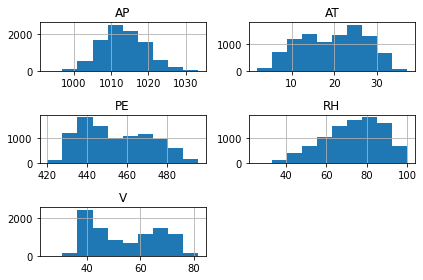

In [433]:
# Inspect data
df[['AT', 'V', 'RH', 'PE', 
    'AP']].hist()
plt.tight_layout();

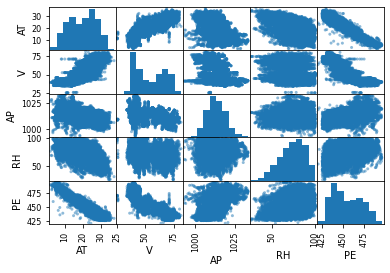

In [434]:
pd.plotting.scatter_matrix(df);

In [435]:
# Put independent and dependent variables into separate dataframes and numpy arrays
Xdf = df[['AT', 'V', 'AP', 'RH']]

ydf = df['PE']

X, y = np.array(Xdf), np.array(ydf)

In [436]:
# Shapiro Wilk test
stats.shapiro(X)

/Users/troybeall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.5875012874603271, pvalue=0.0)

In [437]:
# The data is not normal and ranges are different
# So we standardize data
scaler = StandardScaler()
scaler.fit(Xdf)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler.transform(Xdf)

In [438]:
# Split into testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [439]:
# list of features (names)
features = list(Xdf.columns)
features.insert(0, "Intercept")
features

['Intercept', 'AT', 'V', 'AP', 'RH']

In [440]:
# train model and print summary
Xc = sm.add_constant(X_train)
OLS_model = sm.OLS(y_train,Xc)
results = OLS_model.fit()
results.summary(xname=features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.482e+04
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        19:59:20   Log-Likelihood:                -22493.
No. Observations:                7654   AIC:                         4.500e+04
Df Residuals:                    7649   BIC:                         4.503e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.3878      0.052   8693.110      0.000     454.285     454.490
AT           -14.7288      0.128   -114.925      0.000     -14.980     -14.478
V             -2.9613      0.104    -28.479      0.000      -3.165      -2.757
AP             0.3976      0.063      6.309      0.000       0.274       0.521
RH            -2.3197      0.069    -33.853      0.000      -2.454      -2.185
==============================================================================
Omnibus:                      613.665   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2498.938
Skew:                          -0.311   Prob(JB):                         0.00
Kurtosis:                       5.729   Cond. No.                         4.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [441]:
# Check VIFs
ydf, Xdf = dmatrices('PE ~ AT + V + AP + RH', df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xdf.values, i) for i in range(Xdf.shape[1])]
vif["variables"] = Xdf.columns
vif

,VIF Factor,variables
0,43761.151866,Intercept
1,5.977602,AT
2,3.943003,V
3,1.452639,AP
4,1.705290,RH


In [442]:
pred_val = results.fittedvalues.copy()
true_val = y_train.copy()
residual = true_val - pred_val

In [443]:
model_df = pd.DataFrame() 
model_df['Predicted value'] = pred_val.tolist()
model_df['Observed value'] = true_val.tolist()
model_df['Residual'] = residual.tolist()

In [444]:
model_df.head(10)

,Predicted value,Observed value,Residual
0,476.605020,474.75,-1.855020
1,432.506803,441.67,9.163197
2,479.755779,479.78,0.024221
3,433.586681,435.93,2.343319
4,448.320725,445.33,-2.990725
5,452.855065,457.00,4.144935
6,456.465066,458.06,1.594934
7,436.070691,433.76,-2.310691
8,475.497162,474.36,-1.137162
9,435.079080,432.25,-2.829080


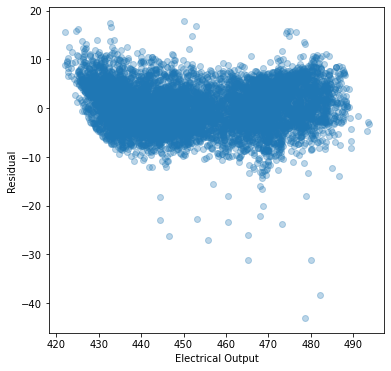

In [445]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(pred_val, residual, alpha=0.3)
ax.set(xlabel="Electrical Output", ylabel = "Residual");

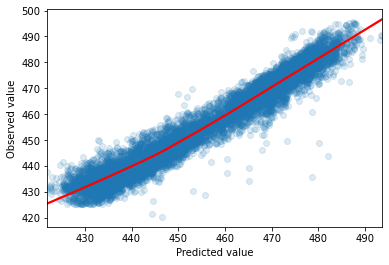

In [446]:
g = sb.regplot(x=pred_val, y=true_val, 
lowess=True, data=df, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})
g.set(xlabel="Predicted value", ylabel = "Observed value");

In [447]:
model_df.describe()

,Predicted value,Observed value,Residual
count,7654.000000,7654.000000,7.654000e+03
mean,454.404630,454.404630,6.186159e-13
std,16.471062,17.093723,4.571593e+00
min,421.952413,420.260000,-4.303055e+01
25%,440.505720,439.692500,-3.168101e+00
50%,452.145525,451.640000,-1.006460e-01
75%,468.861088,468.595000,3.183633e+00
max,493.666908,495.760000,1.775887e+01


In [495]:
#TEST
X_new_test = sm.add_constant(X_test)

In [503]:
test_results = results.predict(X_new_test)

In [504]:

test_true_val = y_test.copy()
test_residual = test_true_val - test_results

In [505]:
test_model_df = pd.DataFrame() 
test_model_df['Predicted value'] = test_results.tolist()
test_model_df['Observed value'] = test_true_val.tolist()
test_model_df['Residual'] = test_residual.tolist()

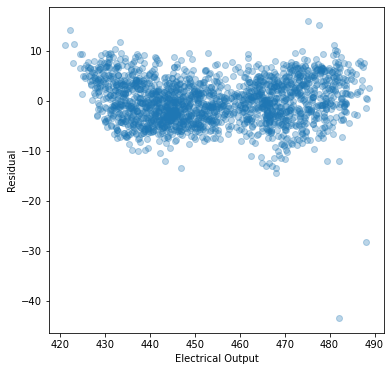

In [508]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(test_results, test_residual, alpha=0.3)
ax.set(xlabel="Electrical Output", ylabel = "Residual");

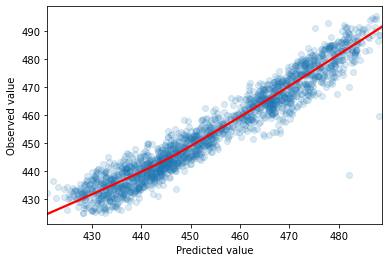

In [509]:
g = sb.regplot(x=test_results, y=test_true_val, 
lowess=True, data=df, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})
g.set(xlabel="Predicted value", ylabel = "Observed value");